In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_optimizer import RAdam
from tqdm.notebook import tqdm
from contextlib import contextmanager
from numba import njit
import warnings
from astropy.convolution import convolve

In [2]:
@contextmanager
def initiate_plot(dimx=24, dimy=9, dpi=100, fontweight='normal'):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    plt.rcParams['font.weight'] = fontweight
    plt.rcParams['mathtext.default'] = 'regular'
    plt.rcParams["font.family"] = 'Arial'
    fig = plt.figure(dpi=dpi)
    yield fig
    plt.show()

In [3]:
def convert_2d_response(x, y, z, xmin, xmax, ymin, ymax, num_bins=15, kernel_size=1, isconvolve=True):
    @njit
    def compute(*args):
        x_bins = np.linspace(xmin - 1, xmax + 1, num_bins + 1)
        y_bins = np.linspace(ymin - 1, ymax + 1, num_bins + 1)

        x_indices = np.digitize(x, x_bins) - 1
        y_indices = np.digitize(y, y_bins) - 1

        data = np.zeros((num_bins, num_bins))
        count = data.copy()
        for z_idx, z_value in enumerate(z):
            data[y_indices[z_idx], x_indices[z_idx]] += z_value
            count[y_indices[z_idx], x_indices[z_idx]] += 1

        data /= count
        return x_bins, y_bins, data
    
    x_bins, y_bins, data = compute(x, y, z, xmin, xmax, ymin, ymax, num_bins)
    xx, yy = np.meshgrid(x_bins, y_bins)
    
    if isconvolve:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            kernel = np.ones((kernel_size, kernel_size))
            data = convolve(data, kernel, boundary='extend')
    return xx, yy, data

In [4]:
def reset_seeds(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
class Arg():
    def __init__(self):
        self.device = 'cuda:0'
        self.env_edgesize = 30
        self.WORLD_DIM = 2
        self.NUM_PCELL = 400
        self.pcell_std = 2.5
        self.traj_len = 200
        self.BUFFER_SIZE = int(5e4)
        self.ACTION_DIM = 9
        self.RNN_SIZE = 64
        self.BN_SIZE = 512
        self.RNN = nn.LSTM
        self.optimzer = RAdam
        self.lr = 5e-4
        self.eps = 1.5e-4
        self.batch_size = 256

In [6]:
class Env(nn.Module):
    def __init__(self, arg):
        super().__init__()
        self.__dict__.update(arg.__dict__)
        reset_seeds()
        
        self.x0_idx = torch.randint(self.env_edgesize, (self.BUFFER_SIZE, self.WORLD_DIM))
        
        self.action_space = list(torch.cartesian_prod(*[torch.arange(-1, 1.1) for _ in range(self.WORLD_DIM)]))
        self.action = torch.zeros((self.traj_len * self.BUFFER_SIZE, self.WORLD_DIM))
        self.action_onehot_space = list(torch.eye(self.ACTION_DIM))
        self.action_onehot = torch.zeros((self.traj_len * self.BUFFER_SIZE, self.ACTION_DIM))
        
        self.action_label = torch.randint(self.ACTION_DIM, (self.traj_len * self.BUFFER_SIZE, ))
        for (label, a), a_onehot in zip(enumerate(self.action_space), self.action_onehot_space):
            self.action[self.action_label == label] = a
            self.action_onehot[self.action_label == label] = a_onehot
            
        self.action = self.action.view(self.traj_len, self.BUFFER_SIZE, -1)
        self.action_onehot = self.action_onehot.view(self.traj_len, self.BUFFER_SIZE, -1).to(arg.device)
        
        self.pcell_center = torch.rand((self.NUM_PCELL, self.WORLD_DIM)) * (self.env_edgesize - 1)
        self.pcell_center = self.pcell_center.unsqueeze(0).repeat((self.BUFFER_SIZE, 1, 1))
        
    def forward(self):
        x_idx = self.x0_idx.clone()
        x_idx_all = []
        states = []
        for t in tqdm(range(self.traj_len)):
            dist = torch.norm(self.pcell_center - x_idx.unsqueeze(1), dim=-1) # shape as BUFFER_SIZE * NUM_PCELL
            state = (- 1 / 2) * (dist / self.pcell_std) ** 2
            state = torch.softmax(state, dim=-1)
            states.append(state)
            x_idx_all.append(x_idx)
        
            x_idx = (x_idx + self.action[t]).clip(min=0, max=self.env_edgesize - 1)
            
        return torch.stack(states).to(self.device), self.action_onehot, torch.stack(x_idx_all)
    

In [7]:
def init_weights(m, mean=0, std=0.1, bias=0):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean, std)
        nn.init.constant_(m.bias, bias)
    if isinstance(m, (nn.LSTM, nn.GRU, nn.RNN)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, bias)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            else:
                raise ValueError()

In [8]:
class Model(nn.Module):
    def __init__(self, arg):
        super().__init__()
        self.__dict__.update(arg.__dict__)
        
        self.hidden0 = nn.Linear(self.NUM_PCELL, self.RNN_SIZE)
        self.cell0 = nn.Linear(self.NUM_PCELL, self.RNN_SIZE)
        self.rnn = self.RNN(input_size=self.ACTION_DIM, hidden_size=self.RNN_SIZE)
        self.l1 = nn.Linear(self.RNN_SIZE, self.BN_SIZE)
        self.dropout = nn.Dropout(p=0.5)
        self.l2 = nn.Linear(self.BN_SIZE, self.NUM_PCELL)
        
        self.apply(init_weights)
        
    def forward(self, a, p0):
        hidden_in = (torch.tanh(self.hidden0(p0)), torch.tanh(self.cell0(p0)))
        x, _ = self.rnn(a, hidden_in)
        x = self.dropout(self.l1(x))
        x = F.log_softmax(self.l2(x), dim=-1)
        return x

In [9]:
class Agent():
    def __init__(self, arg):
        self.__dict__.update(arg.__dict__)
        reset_seeds()
        
        self.model = Model(arg).to(self.device)
        self.model_optim = self.optimzer(self.model.parameters(), lr=self.lr, eps=self.eps)
        self.loss = nn.KLDivLoss(reduction='none')
        
    def learn(self, data, label, epoch_max=int(3e8)):
        for epoch in range(epoch_max):
            self.model_optim.zero_grad()
            mini_batch_idx = np.random.choice(range(self.BUFFER_SIZE), self.batch_size, replace=False)
            mini_batch = data[:, mini_batch_idx, :]
            mini_label = label[:, mini_batch_idx, :]
            
            output = self.model(mini_batch, mini_label[:1])
            loss = self.loss(output, mini_label).mean()
            
            loss.backward()
            self.model_optim.step()
            
            if epoch % 1000 == 0:
                print(loss.item())
                

## Training

In [10]:
arg = Arg()

env = Env(arg)
label, data, position = env()

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
agent = Agent(arg)
agent.learn(data, label)

0.005881801713258028
0.005884435027837753
0.00584391737356782
0.005833769217133522
0.005896862596273422
0.005855259019881487
0.005845603998750448
0.005867660511285067
0.005906130187213421
0.005881088320165873
0.005806152243167162
0.005844695493578911
0.005858843680471182
0.005851570516824722
0.005858281627297401
0.005813660100102425
0.005791109520941973
0.005944313947111368
0.005890029948204756
0.0058441199362277985
0.005865440703928471
0.005825216881930828
0.00583758857101202
0.005813485011458397
0.005807005800306797
0.005865256302058697
0.005886791739612818
0.0058978102169930935
0.005857989192008972
0.00591224106028676
0.005838647484779358
0.005886489991098642
0.005834763403981924
0.005868626292794943
0.00580958416685462
0.005888139363378286
0.005868029780685902
0.005807725712656975
0.005867533851414919
0.0058719078078866005
0.0058815390802919865
0.005841427482664585
0.005817626602947712
0.005836535710841417
0.005864014849066734
0.005864269100129604
0.005816659424453974
0.00583602115

KeyboardInterrupt: 

## Figure

In [12]:
import matplotlib.pyplot as plt
from matplotlib import colors

In [14]:
batch_size = 1000
with torch.no_grad():
    traj = data[:, :batch_size, :]
    x0 = label[:1, :batch_size, :]
    hidden_in = (torch.tanh(agent.model.hidden0(x0)), torch.tanh(agent.model.cell0(x0)))
    x, _ = agent.model.rnn(traj, hidden_in)
    x = agent.model.l1(x)
    
x = x.reshape(-1, x.shape[-1]).cpu().numpy()

In [15]:
position_ = position.numpy()[:, :batch_size, :]
position_ += np.random.randn(*position_.shape) * 0.05
position_ = position_.reshape(-1, position_.shape[-1])

In [16]:
i_all = (i for i in range(x.shape[-1]))

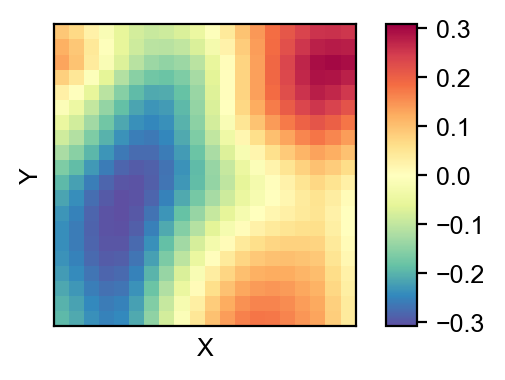

In [20]:
idx = next(i_all)
fontsize = 9
with initiate_plot(2, 2, 200) as fig:
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    plt.xticks([], fontsize=fontsize)
    plt.yticks([], fontsize=fontsize)
    ax.set_xlabel('X', fontsize=fontsize)
    ax.set_ylabel('Y', fontsize=fontsize)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
    r = x[:, idx]
    xx, yy, zz = convert_2d_response(*list(position_.T), r, 1, 29, 1, 29, num_bins=20, kernel_size=3)
    norm = colors.TwoSlopeNorm(vmin=-abs(zz).max(), vcenter=0, vmax=abs(zz).max())
    
    cmeshplot = ax.pcolormesh(xx, yy, zz, cmap='Spectral_r', norm=norm)
    cbaxes = ax.inset_axes([1.1, 0, 0.1, 1]) 
    cbar = fig.colorbar(cmeshplot, cax=cbaxes, orientation='vertical')
    cbar.ax.tick_params(labelsize=fontsize)